**Class 4: Deep Reinforcement Learning.**

1. [Everything you need to know](#everything)
2. [Deep Q-networks](#dqn)
    1. [Pong](#breakout)
    2. [State space](#state)
    3. [Action space](#action)
    4. [Reminder on Q-learning](#reminder)
    5. [Q-networks](#qn)
    6. [Deep Q-networks](#dqnetworks)
    7. [Experience replay](#xpr)
3. [Going further in Deep RL](#moreDeepRL)
4. [Deep Tic-Tac-Toe learning](#ttt)
    1. [The board game](#board)
    2. [Deep Q-Learning](#ttt-dqn)

# <a id="everything"></a>Everything you need to know

Everything you should remember after this session.<br>
<div class="alert alert-success">
<ul>
<li> Deep Q-Learning is Q-learning with a Deep Neural Network as function approximator for $Q$.
<li> Deep Q-Network (DQN): take $s$ as input and output a Q-value per action.
<li> State space for visual tasks (like Atari game): stack the last $m$ frames in the state, $s = (im_0,\ldots,im_m)$.
<li> Experience replay: store a memory of the $N$ last samples and pick a minibatch of $n$ samples for the DQN parameters update at each time step.
</ul>
</div>

Of course, all this seems very obscure right now and the block above will only serve as a reminder when you re-open the notebook later. We will introduce every concept intuitively and progessively.

# <a id="dqn"></a>Deep Q-networks

The ideas we present in this notebook were introduced in the crucial paper **[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)** by Mnih et al. (2013) and was later popularized by DeepMind's paper in Nature **[Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)** by Mnih et al. (2015).

The core idea we develop here is to use a Deep Neural Network architecture to learn the optimal Q-function in a Q-learning algorithm. We will follow closely the presentation of the first reference above (8 pages which are definitely worth reading) and replicate their approach.

Nota: the second paper above actually introduce some improvements and notable differences with the first reference. We review them at the end of this section.

## <a id="breakout"></a>Pong

Let's start by taking a challenging problem: we want to build an agent that learns to play Pong, one of the [Atari games](https://github.com/openai/gym/blob/master/gym/envs/atari/atari_env.py) in Gym (originally in the [Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment)).

You might want to try different games later on (like the popular Breakout game for instance or some games from the [classic control](https://github.com/openai/gym/tree/master/gym/envs/classic_control) series of environments).

In [1]:
import gym
import gym.envs.atari as atari
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

In [2]:
env = gym.make('Pong-v4')

/home/emmanuel/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Here is the environment's description.
> Maximize your score in the Atari 2600 game Pong. In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3). Each action is repeatedly performed for a duration of k frames, where k is uniformly sampled from $\{2, 3, 4\}$.

In [3]:
print(env.observation_space)
print(env.observation_space.shape)
print(np.min(env.observation_space.low))
print(np.max(env.observation_space.high))
print(env.action_space)
#help(env.observation_space)

Box(210, 160, 3)
(210, 160, 3)
0
255
Discrete(6)


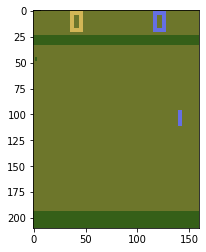

In [4]:
x = env.reset()
plt.imshow(x)
plt.show()

# <a id="state"></a>State space

Let's take a look at the characteristics of this game. Pong is one of the classic Atari 2600 games. We want to build a "human-level" controler so we will define the state of our agent by the set of raw pixels from the current image. This might not be enough to define an informative enough state: for instance, having just a snapshot image only gives us the position of the ball but not its velocity. So we will expand the state so that it contains the 4 last frames from the game.

One frame is a $210\times 160$ RGB image with a 256 color palette, so the set of all possible frames has size $256^{210 \times 160 \times 3} \sim 10^{242579}$. That's a little too many for an efficient enumeration. Even by converting the image to greyscale, downsampling to a $110\times 84$ and then cropping to a $84\times 84$ image to keep only the playing area (as we shall do a little later to slightly simplify the problem), that's still around $10^{16980}$ possible states. So, definitely, this discrete problem is not suitable for complete enumeration.

Of course, most of the possible images will never occur in a Pong game and the true state space is actually a much smaller subset of the full set of possible images. Nevertheless, unless we provide a large engineering effort in describing the state space with few variables (which would be in contradiction with our goal of a "human-level" AI) we will need to automatically discover some structure in the state sampled data.

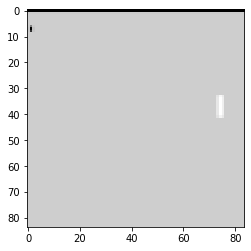

(84, 84)
0.32547956062350203 0.4600406986644189


In [20]:
from skimage.color import rgb2gray
from skimage.transform import resize

def process_screen(x):
    return resize(rgb2gray(x), (110,84))[17:101,:]
    #return 256*resize(rgb2gray(x), (110,84))[17:101,:]

y=process_screen(x)
plt.imshow(y, cmap="gray")
plt.show()
print(y.shape)
print(y.min(), y.max())

In [14]:
# stack the 4 last frames
z = np.stack([y,y,y,y],axis=-1)
print(z.shape)

(84, 84, 4)


## <a id="action"></a>Action space

There are 18 buttons on the Atari controller. However not all games use all buttons. Our interface to Pong specifies 6 possible actions:
- 0 NOOP (no operation)
- 1 FIRE (press fire button, doesn't do anything in Pong)
- 2 RIGHT (actually moves the paddle up in Pong)
- 3 LEFT (actually moves the paddle left in Pong)
- 4 UP (moves the paddle upwards)
- 5 DOWN (moves the paddle downwards)

But really, it goes up to the 6th action for naming consistency (UP and DOWN), because the other actions are not really useful.

Also, for an unknown reason, the game does not start until the 20th frame (but always starts automatically, pressing FIRE does not change anything).

The frame rate is 60Hz.

In [ ]:
#print(atari.atari_env.ACTION_MEANING)

In [15]:
# Trying a random agent in Pong
import time

env.reset()
env.render()
for i in range(60):
    a = 4+np.random.randint(2)
    env.step(a)
    env.render()
    time.sleep(0.1)

env.close()

## <a id="reminder"></a>Reminder on Q-learning

Let's take a minute on the white board for a general recap on everything we have introduced in past classes, to get to this point.

<blockquote> The idea that we learn by interacting with our environment is probably the first to occur to us when we think about the nature of learning. When an infant plays, waves its arms, or looks about, it has no explicit teacher, but it does have a direct sensorimotor connection to its environment. Exercising this connection produces a wealth of information about cause and effect, about the consequences of actions, and about what to do in order to achieve goals. Throughout our lives, such interactions are undoubtedly a major source of knowledge about our environment and ourselves. Whether we are learning to drive a car or to hold a conversation, we are acutely aware of how our environment responds to what we do, and we seek to influence what happens through our behavior. Learning from interaction is a foundational idea underlying nearly all theories of learning and intelligence. (Richard S. Sutton)</blockquote>

## <a id="qn"></a>Q-networks

Recall Q-learning with function approximation:
<blockquote>
Repeat:
<ol>
    <li> In $s$, choose $a$ (<i>GLIE actor</i>)
<li> Observe $r$, $s'$
<li> Temporal difference: $\delta=r+\gamma \max_{a'} Q_\theta(s',a') - Q_\theta(s,a)$
<li> Update $Q_\theta$: $\theta \leftarrow \theta + \alpha \delta \nabla_\theta Q_\theta(s,a)$
<li> $s\leftarrow s'$
</ol>
</blockquote>

Let's re-build this result while considering a neural network function approximator $Q_\theta(s,a)$ with weights $\theta$. We will refer to a neural network function approximator as a **Q-network**.

<img src="images/dqlas.png" height="15%" width="15%"></img>

Given a set of weights $\theta$ defining a given Q-network, one can define a target $y$ as:
$$y(s,a) = \mathbb{E}_{s'}\left( r + \gamma \max_{a'} Q_{\theta}(s',a') \Big| s,a\right)$$

That $y$ target is the expected (over all states $s'$ reachable from $(s,a)$) 1-step best value, given that $Q_\theta$ will be obtained in $s'$. In a Value Iteration fashion, we would like a new Q-network to fit this target, and thus to minimize the loss:
$$L(\theta') = \mathbb{E}_{s,a} \left[ \left(y(s,a) - Q_{\theta'}(s,a)\right)^2 \right]$$

That loss is the mean squared error of the Q-network (over all states and actions).

Our goal is to find the Q-network that fits $Q^*$. To obtain this network, we define a **sequence** of loss functions $L_i(\theta)$ that change at each iteration $i$:
$$L_i(\theta) = \mathbb{E}_{s,a} \left[ \left(y_i(s,a) - Q_\theta(s,a)\right)^2 \right]$$

It is important to note several things:
- $L_i(\theta)$ depends on $y_i(s,a) = \mathbb{E}_{s'}\left( r + \gamma \max_{a'} Q_{\theta_{i-1}}(s',a') \Big| s,a\right)$ and thus on $\theta_{i-1}$.
- $\theta_{i-1}$ is held fixed when optimizing $\theta_i$.

Differentiating the loss function with respect to the weights $\theta$ we obtain:
$$\nabla_\theta L_i(\theta) = -2 \mathbb{E}_{s,a,s'} \left[ \left( r + \gamma \max_{a'} Q_{\theta_{i-1}} (s',a') - Q_\theta(s,a) \right) \nabla_\theta Q_\theta(s,a) \right]$$

Let's take a minute to consider the $\mathbb{E}_{s,a,s'}$ in this gradient. The probability of observing a pair $s,a$ is called the *behaviour distribution*; when sampling by interacting with the environment, it depends on the policy being applied. But in our case, we want to cover the full reachable state-action space efficiently. That is, we want to have non-zero probability in all reachable state-action pairs and (preferably) important probability mass on pairs that are important for the optimal policy. This is, in the end, a reformulation of the exploration vs. exploitation compromise, which can be solved using $\epsilon$-greedy sampling strategies. The probability of observing $s'$ can be estimated through sampling by interaction, it requires however to obtain enough samples in each pair $(s,a)$.

Rather than computing the full expectation in the gradient above, one often turns to stochastic gradient descent to minimize $L_i$. If the weights are updated every time a sample $(s,a,r,s')$ is collected and if the expectation $\mathbb{E}_{s,a,s'}$ is replaced by single sample estimates from a behaviour distribution and the environment's dynamics, then one obtains the standard Q-learning update given at the beginning of this section.
$$\delta=r+\gamma \max_{a'} Q_{\theta_{i-1}}(s',a') - Q_\theta(s,a)$$
$$\theta \leftarrow \theta + \alpha \delta \nabla_\theta Q_\theta(s,a)$$

## <a id="dqnetworks"></a>Deep Q-networks

Let's define a Convolutional Neural Network (CNN) that will predict our Q-values. When we choose a greedy action, we need to evaluate $Q(s,a)$ for all possible $a$. So in our case, that means propagating $(s,a)$ values 2 times through our network. In a more complex game that requires $n$ buttons on the Atari controller, that would require $n$ propagations through the network. It would be more efficient to build a network that predicts the values of the 2 actions in a single pass for a given state $s$. So we define the input of our Q-network as the state only, and the output as the 2-dimensional vector evaluating each action.

<img src="images/dqls.png" height="30%" width="30%"></img>

Then, our network has the following structure:
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 16 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 32 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Fully connected with 256 ReLU units
- layer 4 (output): Fully connected with 2 linear units (one for each action's value)

Graphically, this yields the following network structure.
<img src="images/dqn.png"></img>

We refer to this type of CNN as *Deep Q-Networks*.

In [16]:
import torch
import torch.nn as nn

fake_state = torch.randn(4,84,84)
print("Input image size:", fake_state.shape)
c1 = nn.Conv2d(in_channels=4, out_channels=16,kernel_size=(8,8),stride=(4,4))
x1 = c1(fake_state.unsqueeze(0))
print("After 1st conv layer:", x1.shape[1:])
c2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4,4), stride=(2,2))
x2 = c2(x1)
print("After 2nd conv layer:", x2.shape[1:])
flattened_size=1
for s in x2.shape[1:]:
    flattened_size *= s
print("After flattening:", flattened_size)

Input image size: torch.Size([4, 84, 84])
After 1st conv layer: torch.Size([16, 20, 20])
After 2nd conv layer: torch.Size([32, 9, 9])
After flattening: 2592


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16,kernel_size=(8,8),stride=(4,4))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4,4), stride=(2,2))
        self.fc1   = nn.Linear(in_features=2592, out_features=256)
        self.fc2   = nn.Linear(in_features=256, out_features=2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,2592)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
import torch.optim as optim

dqn = DQN()

Qpred = dqn.forward(fake_state.unsqueeze(0))
Qtarget = torch.empty(2)
mse = nn.MSELoss()
loss = mse(Qpred,Qtarget)

optimizer = optim.RMSprop(dqn.parameters())

print(dqn)
print(loss)
print(optimizer)

DQN(
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=2592, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)
tensor(0.0042, grad_fn=<MseLossBackward>)
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)


/home/emmanuel/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## <a id="xpr"></a>Experience replay

It is known that learning directly from consecutive samples is inefficient. The main reason is that these samples are strongly correlated with each other and learning sample by sample has the same risk of *catastrophic forgetting* that we already saw in Deep Learning. In other words, we risk forgetting about what was learned previously in some region of the state-action space, if we flood the Q-network with too many samples from another region.

In Deep Learning, this limitation was overcome by the introduction of mini-batches. Experience replay in Reinforcement Learning is a very similar approach that stores samples $(s,a,r,s')$ in a so-called *replay memory* $\mathcal{D}$ for $N$ time steps. Then, when updating the network's parameters, a mini-batch of $\mathcal{D}$ is uniformly sampled in order to compute the gradient.

Experience replay has three main advantages:
- Each sample $(s,a,r,s')$ can be reused in many updates (although this is not a N-step update, it allows a better usage of samples).
- Randomizing the mini-batch over the replay memory breaks the correlations between samples and thus reduces the variance of weights updates.
- The bias in exploration due to overestimating some Q-values (because of a tendency of neural networks to focus on the last samples) is reduced. Thus exploration is more efficient and we have less risk of getting stuck in local minima of the loss function.

<a href="#xp-replay" data-toggle="collapse"> Remarks</a><br>
<div id="xp-replay" class="collapse">
<ul>
<li> Our replay memory has finite length, we can still forget old samples. We have made our algorithm more robust but, yes, we still face catastrophic forgetting. For more refined approaches at remembering long term experience, see the usage of Recurrent Neural Networks in <a href="https://arxiv.org/pdf/1507.06527.pdf">this paper</a> for instance.
<li> The choice of uniform sampling within the replay memory is somehow a bit naive. We have seen in previous classes that the ordering of Bellman backups (in the model-based case) or TD updates (in the model-free case) have an importance in the convergence speed of the algorithm. Therefore, it would be beneficial to use a non-uniform distribution over samples in our experience replay procedure. This was developped in the <a href="https://arxiv.org/pdf/1511.05952.pdf">Prioritized Experience Replay</a> algorithm. That uses the TD error to approximate the Bellman residual and define update priorities.
<li> Experience replay *requires* an off-policy algorithm (thus it is not compatible with SARSA).
</ul>
</div>

Given this last idea, lets implement an Experience Replay Q-learning using our DQN. The algorithm's pseudo-code is:

         state = init()
         loop:
            action = greedy_action(DQN) or random_action()
            new_state, reward = step(state, action)
            replay_memory.add(state, action, reward, new_state)
            minibatch = replay_memory.sample(minibatch_size)
            X_train = Y_train = []
            for (s,a,r,s') in minibatch:
                Q  = DQN.predict(s)
                Q' = DQN.predict(s')
                if non-terminal(s'): 
                    update = r + gamma * max(Q')    
                else:  
                    update = r
                Q[a] = update
                X_train.add(s)
                Y_train.add(Q)
            DQN.train_one_step(X_train,Y_train)
            state = new_state

A few algorithmic details:
- Total number of steps: $10^7$.
- Replay memory size: $10^6$ samples.
- Mini-batch size: $32$ samples.
- $\gamma = 0.99$
- Reward clipping. To control the scale of the global scores, clip the rewards so that all strictly positive rewards are $+1$, all zero rewards remain at $0$, and strictly negative rewards become $-1$.
- Epsilon greedy. Decrease linearly $\epsilon$ from $1$ to $0.1$ over the first million steps and keep it at $0.1$ thereafter.

<div class="alert alert-danger">
    
**Warning:** the network training defined below might take very (very!) long. For example, on an i7 CPU with no GPU it takes about 10 days. Also, the replay memory of $10^7$ samples uses around 10Gb of RAM as defined below. If your machine's resources are below that, you might want to scale down the replay memory size. Therefore, only run this code if you have time ahead of you. A simpler example is given later in the notebook.</div>

In [19]:
total_steps = 10000000
replay_memory_size = 1000000
mini_batch_size = 32
gamma = 0.99

def epsilon(step):
    if step<1e6:
        return 1.-step*9e-7
    return .1

def clip_reward(r):
    rr=0
    if r>0:
        rr=1
    if r<0:
        rr=-1
    return rr

def greedy_action(network, state):
    Q = network.forward(state.unsqueeze(0))
    return torch.argmax(Q[0])

def MCeval(network, trials, length, gamma):
    scores = np.zeros((trials))
    for i in range(trials):
        screen_x = process_screen(env.reset())
        stacked_x = deque([screen_x, screen_x, screen_x, screen_x], maxlen=4)
        x = np.stack(stacked_x, axis=-1)
        for t in range(length):
            a = greedy_action(network, x)
            raw_screen_y, r, d, _ = env.step(a)
            r = clip_reward(r)
            screen_y = process_screen(raw_screen_y)
            scores[i] = scores[i] + gamma**t * r
            if d==True:
                # restart episode
                break
            else:
                # keep going
                screen_x = screen_y
                stacked_x.append(screen_x)
                x = np.stack(stacked_x, axis=-1)
    return np.mean(scores)


In [ ]:
print(dqn(fake_state.unsqueeze(0)).detach().numpy())
print(greedy_action(dqn,fake_state).numpy())

In [ ]:
# A class for the replay memory
from collections import deque

class MemoryBuffer:
    "An experience replay buffer using numpy arrays (for PyTorch networks)"
    def __init__(self, length, screen_shape, action_shape):
        self.length = length
        self.screen_shape = screen_shape
        self.action_shape = action_shape
        shape = (length,) + screen_shape
        self.screens_x = np.zeros(shape, dtype=np.uint8) # starting states
        self.screens_y = np.zeros(shape, dtype=np.uint8) # resulting states
        shape = (length,) + action_shape
        self.actions = np.zeros(shape, dtype=np.uint8) # actions
        self.rewards = np.zeros((length,1), dtype=np.uint8) # rewards
        self.terminals = np.zeros((length,1), dtype=np.bool) # true if resulting state is terminal
        self.terminals[-1] = True
        self.index = 0 # points one position past the last inserted element
        self.size = 0 # current size of the buffer
    
    def append(self, screenx, a, r, screeny, d):
        self.screens_x[self.index] = 256*screenx
        #plt.imshow(screenx)
        #plt.show()
        #plt.imshow(self.screens_x[self.index])
        #plt.show()
        self.actions[self.index] = a
        self.rewards[self.index] = r
        self.screens_y[self.index] = screeny
        self.terminals[self.index] = d
        self.index = (self.index+1) % self.length
        self.size = np.min([self.size+1,self.length])
    
    def stacked_frames_x(self, index):
        im_deque = deque(maxlen=4)
        pos = index % self.length
        for i in range(4): # todo
            im = self.screens_x[pos]
            im_deque.appendleft(im)
            test_pos = (pos-1) % self.length
            if self.terminals[test_pos] == False:
                pos = test_pos
        return np.stack(im_deque, axis=0)
    
    def stacked_frames_y(self, index):
        im_deque = deque(maxlen=4)
        pos = index % self.length
        for i in range(4): # todo
            im = self.screens_y[pos]
            im_deque.appendleft(im)
            test_pos = (pos-1) % self.length
            if self.terminals[test_pos] == False:
                pos = test_pos
        return np.stack(im_deque, axis=0)
    
    def minibatch(self, size):
        #return np.random.choice(self.data[:self.size], size=sz, replace=False)
        indices = np.random.choice(self.size, size=size, replace=False)
        x = np.zeros((size,)+(4,)+self.screen_shape)
        y = np.zeros((size,)+(4,)+self.screen_shape)
        for i in range(size):
            x[i] = self.stacked_frames_x(indices[i])
            y[i] = self.stacked_frames_y(indices[i])
        return x, self.actions[indices], self.rewards[indices], y, self.terminals[indices]

In [ ]:
replay_memory = MemoryBuffer(replay_memory_size, (84, 84), (1,))
fake_screen = np.random.randn(84,84)
replay_memory.append(screenx=fake_screen, a=0, r=0., screeny=fake_screen, d=False)
replay_memory.append(screenx=fake_screen, a=0, r=0., screeny=fake_screen, d=False)
replay_memory.append(screenx=fake_screen, a=0, r=0., screeny=fake_screen, d=False)
replay_memory.append(screenx=fake_screen, a=0, r=0., screeny=fake_screen, d=False)
replay_memory.append(screenx=fake_screen, a=0, r=0., screeny=fake_screen, d=False)
replay_memory.append(screenx=fake_screen, a=0, r=0., screeny=fake_screen, d=False)
replay_memory.append(screenx=fake_screen, a=0, r=0., screeny=fake_screen, d=False)
replay_memory.append(screenx=fake_screen, a=0, r=0., screeny=fake_screen, d=False)
print(replay_memory.size)
X,A,R,Y,D = replay_memory.minibatch(3)
print(X.shape)
print(A.shape)
print(R.shape)
print(Y.shape)
print(D.shape)

In [ ]:
print(fake_state.unsqueeze(0).shape)
print(fake_state.dtype)
Xtorch = torch.from_numpy(X)
print(X.shape, X.dtype)
print(Xtorch.shape)
print(Xtorch.dtype)
dqn.forward(torch.from_numpy(X))

In [ ]:
# initialize state and replay memory
screen_x = process_screen(env.reset())
stacked_x = deque([screen_x, screen_x, screen_x, screen_x], maxlen=4)
x = np.stack(stacked_x, axis=0)
replay_memory = MemoryBuffer(replay_memory_size, (84, 84), (1,))
# initial state for evaluation
evaluation_period = 10000
Xtest = np.array([x])
nb_epochs = total_steps // evaluation_period
epoch=-1
scoreQ = np.zeros((nb_epochs))
scoreMC = np.zeros((nb_epochs))

# Deep Q-learning with experience replay
for step in range(total_steps):
    # evaluation
    if(step%10000 == 0):
        print("\r", "step =", step, "/", total_steps, end="")
        epoch = epoch+1
        # evaluation of initial state
        scoreQ[epoch] = np.mean(dqn.forward(Xtest.unsqueeze(0)).detach().max(1))
        # roll-out evaluation
        scoreMC[epoch] = MCeval(network=dqn, trials=20, length=700, gamma=gamma)
    # action selection
    if np.random.rand() < epsilon(step):
        a = np.random.randint(env.action_space.n)
    else:
        a = greedy_action(dqn, x).numpy()
    # step
    raw_screen_y, r, d, _ = env.step(a)
    r = clip_reward(r)
    screen_y = process_screen(raw_screen_y)
    replay_memory.append(screen_x, a, r, screen_y, d)
    # train
    if step>mini_batch_size:
        X,A,R,Y,D = replay_memory.minibatch(mini_batch_size)
        QY = dqn.predict(Y)
        QYmax = QY.max(1).reshape((mini_batch_size,1))
        update = R + gamma * (1-D) * QYmax
        QX = dqn.predict(X)
        QX[np.arange(mini_batch_size), A.ravel()] = update.ravel()
        dqn.train_on_batch(x=X, y=QX)
    # prepare next transition
    if d==True:
        # restart episode
        screen_x = process_screen(env.reset())
        stacked_x = deque([screen_x, screen_x, screen_x, screen_x], maxlen=4)
        x = np.stack(stacked_x, axis=-1)
    else:
        # keep going
        screen_x = screen_y
        stacked_x.append(screen_x)
        x = np.stack(stacked_x, axis=-1)

Below is a video of what you should get (along and) after training:

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("TmPfTpjtdgg")

<div class="alert-warning">**Exercice**:<br>
Read the [Nature paper](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning) on DQN and note the differences with the implementation above. Then modify the code above to match the contents of this paper.
</div>

# <a id="moreDeepRL"></a>Going further in Deep RL

Lots of things to learn, the field has been blooming for the last years. Parallelization, sample efficiency, distribution estimation, network stabilization... many hot topics.

In ISAE: SuReLI, the Supaero Reinforcement Learning Initiative!

# <a id="ttt"></a>Deep Tic-Tac-Toe learning

Let's implement the DQN algorithm on a simple Tic-Tac-Toe game.

## <a id="board"></a>The board game

This is a quite simple implementation. The board is a tuple of size 9 where each action refers to a position in the tuple. We store the status of the current player and who won the game.

We see above the function that we have to develop ... Lets do that.

The main classes and objects:

* joueur(state) 
* available_move(state)
* next_state(state, action, current_player)
* win(board, player)
* payoff(current_player, state) 
* play(state, action)

In [ ]:
class oxo:
    def __init__(self):
        self.current_player = 1
        self.actions = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        self.board = (0,0,0,0,0,0,0,0,0)
        self.nb_move = 0
        self.end_game = 0 # -1: null, O: running, 1: player 1 win, 2: player 2 win

    def play(self, state, action):
        self.current_player = self.joueur(state)
        stateList = list(self.board)
        stateList[action] = self.current_player
        self.board = tuple(stateList)
        self.nb_move += 1
        #print("nb move: ", self.nb_move)
        self.actions.remove(action)
        
        if self.asWin():
            self.end_game = self.current_player
        if self.nb_move == 9 and self.end_game == 0:
            self.end_game = -1

    def next_state(self, state, action, player):
        stateList = list(state)
        stateList[action] = player
        return tuple(stateList)

    def available_move(self, state):
        am = []
        i = 0;
        for x in state:
            if x == 0: 
                am += [i]
            i += 1
        return am

    def asWin(self):
        p = self.current_player
        b = self.board
        if (b[0] == b[1] == b[2] == p or b[3] == b[4] == b[5] == p or b[6] == b[7] == b[8] == p or
            b[0] == b[3] == b[6] == p or b[1] == b[4] == b[7] == p or b[2] == b[5] == b[8] == p or
            b[0] == b[4] == b[8] == p or b[2] == b[4] == b[6] == p):
            return True
        else: return False

    def win(self, b, p):
        if (b[0] == b[1] == b[2] == p or b[3] == b[4] == b[5] == p or b[6] == b[7] == b[8] == p or
            b[0] == b[3] == b[6] == p or b[1] == b[4] == b[7] == p or b[2] == b[5] == b[8] == p or
            b[0] == b[4] == b[8] == p or b[2] == b[4] == b[6] == p):
            return True
        else: return False
        

    # -1: runnin, 0; execo, 1 joueur 1, 2 joueur 2    
    def payoff(self, p, b):
        nb_move = 0
        for i in b:
            if i != 0: nb_move += 1

        if self.win(b, 1):    return 1
        if self.win(b, 2):    return 2    
        if nb_move == 9: return 0        
        return -1

    def joueur(self, board):
        J1=0
        J2=0
        for i in board:
            if i==1: J1+=1 
            if i==2: J2+=1 
        if J1==J2: return 1
        return(2)

    def simulation(self):
        while self.end_game == 0:
            self.myPrint()
            print ("actions ", self.actions)
            action = int(input("Player %s: " % (self.current_player)))

            if action in self.actions: self.play(self.board, action)
            else: print ("wrong move, try again")

            if self.asWin(): 
                print("Player " , self.current_player , " win!!!")
                self.end_game = self.current_player

            if self.nb_move == 9 and self.end_game == 0: 
                print("No winner, No looser!")
                self.end_game == -1

            if self.current_player == 1: self.current_player = 2
            else: self.current_player = 1

    def myPrint(self):
        b = []
        for x in self.board:
            if x == 1: b.append('X')
            else: 
                if x == 2: b.append('O')
                else: b.append('.')
        print()
        print("     ", b[0] , "  " , b[1] , "  " , b[2], "       ", 0 , "  " , 1 , "  " , 2)
        print("     ", b[3] , "  " , b[4] , "  " , b[5], "  ->   ", 3 , "  " , 4 , "  " , 5)
        print("     ", b[6] , "  " , b[7] , "  " , b[8], "       ", 6 , "  " , 7 , "  " , 8)
        print()

## <a id="ttt-dqn"></a>Deep Q learning 

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, sgd
from keras.layers.recurrent import LSTM
import numpy as np
import random
from IPython.display import clear_output

Now we have to build our deep neural network model. 

>Be aware that there is no formal way to design deep neural networks and the accuracy of your neural architectures will depends on your expererience, knowledge and ... intuition :)

Our architecture should take in input a state vector. According to our board game implementation, a state is a vector of 9 digits: (0,0,0,0,0,0,0,0,0) that correspond to the 9 squares of our game board. In output our architecture should provide 9 values that correspond to the Q-value for the 9 possible actions.

I suggest two very basic architectures, but feel free to try your own. 

Note: Dense layer takes in input a 2D vector. LTSM takes a 3D vector.

In [ ]:
model = Sequential()

'''
# !! input shape = (1, 1, len(input)) !!
model.add(LSTM(input_dim=9,output_dim=150,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(9, init='lecun_uniform'))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="rmsprop")
'''

model.add(Dense(150, init='lecun_uniform', input_shape=(9,)))
model.add(Activation('relu'))
model.add(Dropout(0.2)) 
model.add(Dense(150, init='lecun_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(9, init='lecun_uniform'))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer="rmsprop")

We define some parameters used by our deep network

In [ ]:
epochs = 1000
gamma = 0.99 # discount factor
epsilon = 1 # epsilon-greddy

update=0 
alpha=0.1 # learning rate
experience_replay=True
batchSize = 40 # mini batch size
buffer = 1000
replay = [] # init vector buffer
h=0 # current size of the vector buffer

We initialise the game

In [ ]:
jeu = oxo()

and develop our deep Q learning with and without minibatch

In [ ]:
for i in range(epochs):
    jeu = oxo()
    state = jeu.board
    current_player = jeu.joueur(state)
    
    while(jeu.end_game==0):
        current_player = jeu.joueur(state)
        qval = model.predict(np.array(state).reshape(1,len(state)), batch_size=batchSize)
        if (random.random() < epsilon): # exploration exploitation strategy    
            rand = np.random.randint(0,len(jeu.actions))
            action = jeu.actions[rand]
        else: #choose best action from Q(s,a) values
            qval_av_action = [-9999]*9
            for ac in jeu.actions:
                qval_av_action[ac] = qval[0][ac]
            action = (np.argmax(qval_av_action))
        #Take action, observe new state S'
        #Observe reward
        jeu.play(state, action)
        new_state = jeu.board
        # choose new reward values
        reward = -5
        if jeu.payoff(current_player, new_state) == current_player:
            reward = 2
        if jeu.payoff(current_player, new_state) == 0:
            reward = 1
        if jeu.payoff(current_player, new_state) == -1:
            reward = 0
            
        if not experience_replay:
            #Get max_Q(S',a)
            newQ = model.predict(np.array(new_state).reshape(1,len(state)), batch_size=batchSize)
            maxQ = np.max(newQ)
            y = np.zeros((1,9))
            y[:] = qval[:]
            if reward != 0: #non-terminal state
                update = (reward + gamma * maxQ)
            else:
                update = reward
            y[0][action] = update #target output
            print("Game #: %s" % (i,))
            model.fit(np.array(state).reshape(1, len(state)), y, batch_size=batchSize, nb_epoch=1, verbose=1)
            state = new_state
            clear_output(wait=True)
            
        else:
            #Experience replay storage
            if (len(replay) < buffer): #if buffer not filled, add to it
                replay.append((state, action, reward, new_state))
            else: #if buffer full, overwrite old values
                if (h < (buffer-1)):
                    h += 1
                else:
                    h = 0
                replay[h] = (state, action, reward, new_state)
                #randomly sample our experience replay memory
            
            if(len(replay)>batchSize):
                minibatch = random.sample(replay, batchSize)
                X_train = []
                y_train = []
                for memory in minibatch:
                    #Get max_Q(S',a)
                    old_state, action, reward, new_state = memory
                    old_qval = model.predict(np.array(old_state).reshape(1,len(old_state)), batch_size=1)
                    newQ = model.predict(np.array(new_state).reshape(1,len(new_state)), batch_size=1)
                    maxQ = np.max(newQ)
                    y = old_qval[:]
                    if reward != 0: #non-terminal state
                        update = (reward + (gamma * maxQ))
                    else: #terminal state
                        update = reward
                    y[0][action] = update
                    X_train.append(np.array(old_state).reshape(len(old_state),))
                    y_train.append(np.array(y).reshape(9,))
    
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                print("Game #: %s" % (i,))
                model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=1)
                state = new_state
            clear_output(wait=True)
        # update exploitation / exploration strategy
        if epsilon > 0.1:
            epsilon -= (1.0/epochs)
    
        # save the model every 1000 epochs
        if i%1000 == 0:
            model.save("model_dql_oxo_dense.dqf")

So now, we could develop a test function to play with our deep Q learning agent

In [ ]:
def testAlgo(model, playerIA):
    loop = True
    while (loop):
        jeu = oxo()
        #switch first player at each tour
        if playerIA==1:
            playerIA=2
        else:
            playerIA=1
        #while game still in progress
        while(jeu.end_game==0):
            state = jeu.board
            current_player = jeu.joueur(state)
            b = current_player
            # des X et des O au lieu de 1 et 2
            if b == 1: b='X'
            else: b = 'O'
            
            if current_player == playerIA: 
                
                qval = model.predict(np.array(state).reshape(1, len(state)), batch_size=batchSize)
                print("State=", state)
                print("Actions:", jeu.actions)
                for i in range(len(qval[0])):
                    print("     Action:", i, "Q-value:", qval[0][i])
                qval_av_action = [-9999]*9
                for ac in jeu.actions:
                    qval_av_action[ac] = qval[0][ac]
                #print(qval_av_action)
                action = (np.argmax(qval_av_action))
                print("Action:", action)
            else:
                jeu.myPrint()
                print ("action ", jeu.actions, " current_player = ", b)
                action = int(input("Player %s: " % (current_player)))
        
            if action == 10:
                loop=False
                break 
            
            if action in jeu.actions: 
                jeu.play(state, action)
            else: 
                print ("----- > Wrong move, try again!")
                
            if jeu.asWin():
                if current_player == playerIA:
                    print("------------------------------")
                    print("--------->  AI WIN <----------")
                    print("------------------------------")
                else:
                    print("------------------------------")
                    print("----------> YOU WIN <---------")
                    print("------------------------------")
             
            if jeu.nb_move == 9 and jeu.end_game == 0:
                print("------------------------------")
                print("---> No winner, No looser <---")
                print("------------------------------")
            
            #clear_output(wait=True)


Obviously, our agent will be very poor. The network will converge only after a long time, we are here only with CPU and a lot of optimisation could be done to enhance and speed up the deep network.

In [ ]:
model.summary()    

In [ ]:
testAlgo(model, 2)